This notebook shows how to use the CNN-LSTM model to predict the global temperature map.

By Weiwei Zhan

Reference: https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/CNN-LTSM_model.ipynb

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-01-05 14:22:15.000905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocessing: prepare data for training & test sets

#### import data as training & test sets

In [3]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2, CH4, **SO2, BC (black carbon)** <br/>
predictand: tas

**Note:** we here include *two additional predictors*: SO2 & BC. SO2 & BC inputs are 2-D maps, while CO2 & CH4 are 1-D time series

In [4]:
y_train_np = y_train_xr['tas'].data
y_test_np  = y_test_xr['tas'].data

#### Data Normalization

In [5]:
# Compute mean/std of each variable for the whole dataset
meanstd_inputs = {}
predictors     = ['CO2', 'CH4', 'SO2', 'BC']
for var in predictors:
    meanstd_inputs[var] = (X_train_xr[var].data.mean(),X_train_xr[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = X_train_xr[var].dims
    X_train_xr = X_train_xr.assign({var: (var_dims, normalize(X_train_xr[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = X_test_xr[var].dims
    X_test_xr = X_test_xr.assign({var: (var_dims, normalize(X_test_xr[var].data, var, meanstd_inputs))})

In [6]:
X_train_np = X_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data
X_test_np  = X_test_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(753, 96, 144, 4) (753, 96, 144) (86, 96, 144, 4) (86, 96, 144)


Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, n_latitude, n_longitude, n_features]**

Here the lag time step is set to **5**

In [7]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
n_samples   = X_train_np.shape[0] - (slider-1)*len(X_length)
n_lat,n_lon,n_feature = X_train_np.shape[1:]

X_train = np.zeros([n_samples,slider,n_lat,n_lon,n_feature])
y_train = np.zeros([n_samples,1,n_lat,n_lon])

n_start = 0
for i in range(len(X_length)):
    
    X_subset = X_train_np[start[i]:end[i],:]
    y_subset = y_train_np[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    # print(X_subset.shape,y_subset.shape)
    n_length = X_subset.shape[0]
    X_train[n_start:n_start+n_length,:,:,:,:] = X_subset
    y_train[n_start:n_start+n_length,:,:,:]   = y_subset
    n_start += n_length
    
X_test  = np.array([X_test_np[i:i+slider] for i in range(0, X_test_np.shape[0]-slider+1)])


In [8]:
print(X_train.shape,y_train.shape,X_test.shape)

(729, 5, 96, 144, 4) (729, 1, 96, 144) (82, 5, 96, 144, 4)


### 2. Define the CNN-LSTM structure

In [9]:
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
n_lstm_unit = 25 # number of LSTM units
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 64   # batch size
num_epochs     = 50   # number of total epochs

In [10]:
model = Sequential()

model.add(Input(shape=(slider, n_lat,n_lon,n_feature)))
model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(slider, n_lat,n_lon,n_feature)))
model.add(TimeDistributed(AveragePooling2D(pool_size)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(LSTM(n_lstm_unit, activation=activation))
model.add(Dense(n_lat*n_lon))
model.add(Activation('linear'))
model.add(Reshape((1, n_lat, n_lon)))


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 96, 144, 20)   740       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 48, 72, 20)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 20)            0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 25)                4600      
                                                                 
 dense (Dense)               (None, 13824)             359424    
                                                        

2023-01-05 14:22:35.356383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/nvidia/lib64
2023-01-05 14:22:35.356427: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


### 3. Train & save the model

In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/50


2023-01-05 14:22:36.562343: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 644751360 exceeds 10% of free system memory.
2023-01-05 14:22:37.203862: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32237568 exceeds 10% of free system memory.
2023-01-05 14:22:38.765214: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 70778880 exceeds 10% of free system memory.
2023-01-05 14:22:38.765302: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 70778880 exceeds 10% of free system memory.
2023-01-05 14:22:38.769339: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 70778880 exceeds 10% of free system memory.


10/10 [==============================] - 15s 1s/step - loss: 3.8003 - val_loss: 0.4774
Epoch 2/50
10/10 [==============================] - 12s 1s/step - loss: 3.5981 - val_loss: 0.5006
Epoch 3/50
10/10 [==============================] - 12s 1s/step - loss: 2.6593 - val_loss: 0.5723
Epoch 4/50
10/10 [==============================] - 12s 1s/step - loss: 1.4774 - val_loss: 0.6537
Epoch 5/50
10/10 [==============================] - 12s 1s/step - loss: 0.9551 - val_loss: 0.7962
Epoch 6/50
10/10 [==============================] - 12s 1s/step - loss: 0.7699 - val_loss: 0.8462
Epoch 7/50
10/10 [==============================] - 12s 1s/step - loss: 0.6245 - val_loss: 0.8692
Epoch 8/50
10/10 [==============================] - 12s 1s/step - loss: 0.5068 - val_loss: 0.8597
Epoch 9/50
10/10 [==============================] - 12s 1s/step - loss: 0.4240 - val_loss: 0.8287
Epoch 10/50
10/10 [==============================] - 12s 1s/step - loss: 0.3834 - val_loss: 0.6917
Epoch 11/50
10/10 [===========

In [12]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [13]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'CNN-LSTM_model.h5'))

### 4. Evaluate the trained model

In [14]:
# reload the saved model
model = load_model(os.path.join(model_path,'CNN-LSTM_model.h5'))

In [15]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 [==============================] - 1s 177ms/step


First we check whether the ML model can capture the spatial distribution of global temperature

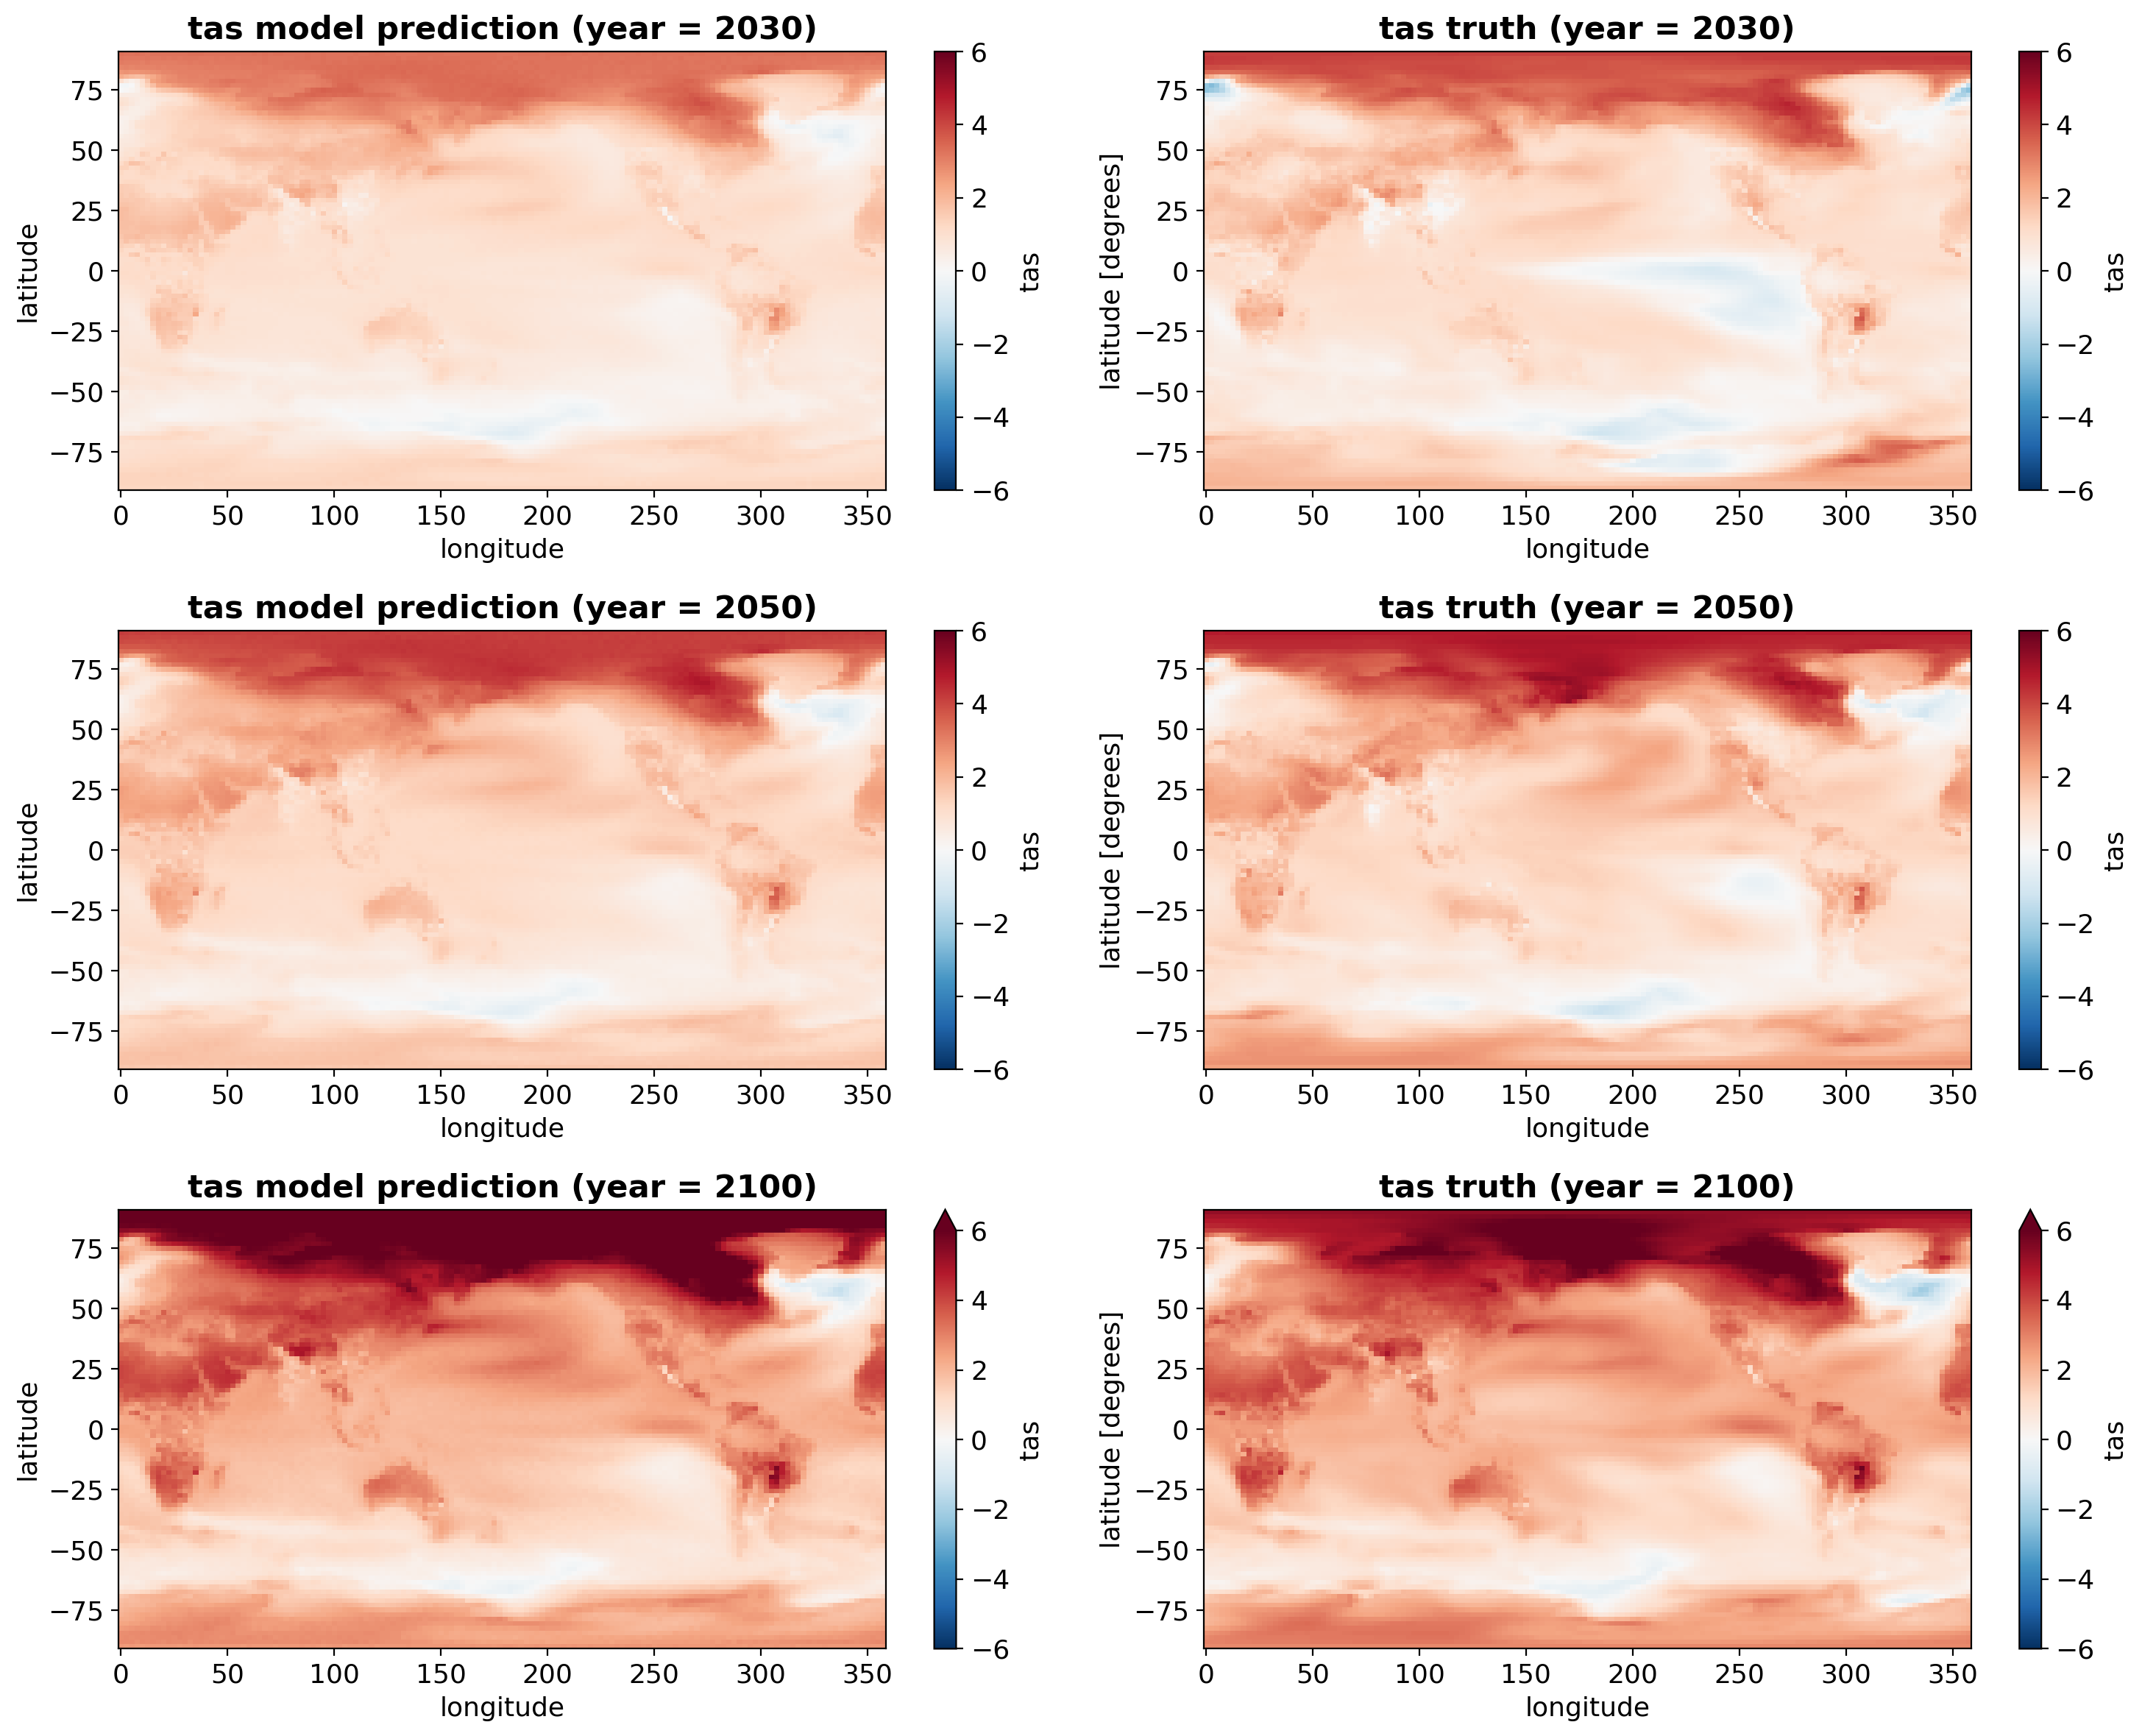

In [16]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

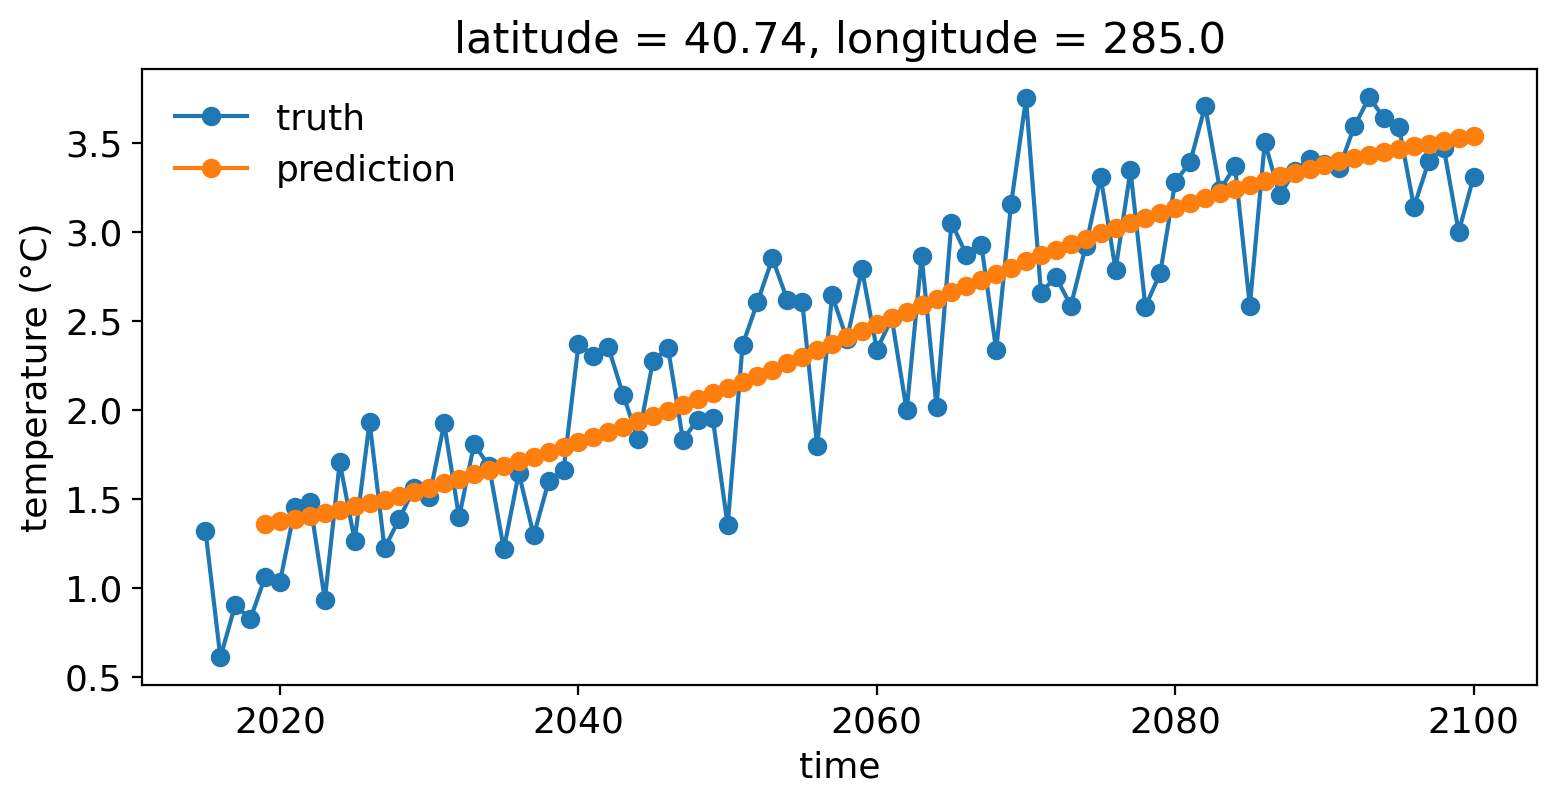

In [17]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

Finally we check whether the ML model can capture the time series of global average temperature 

In [18]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

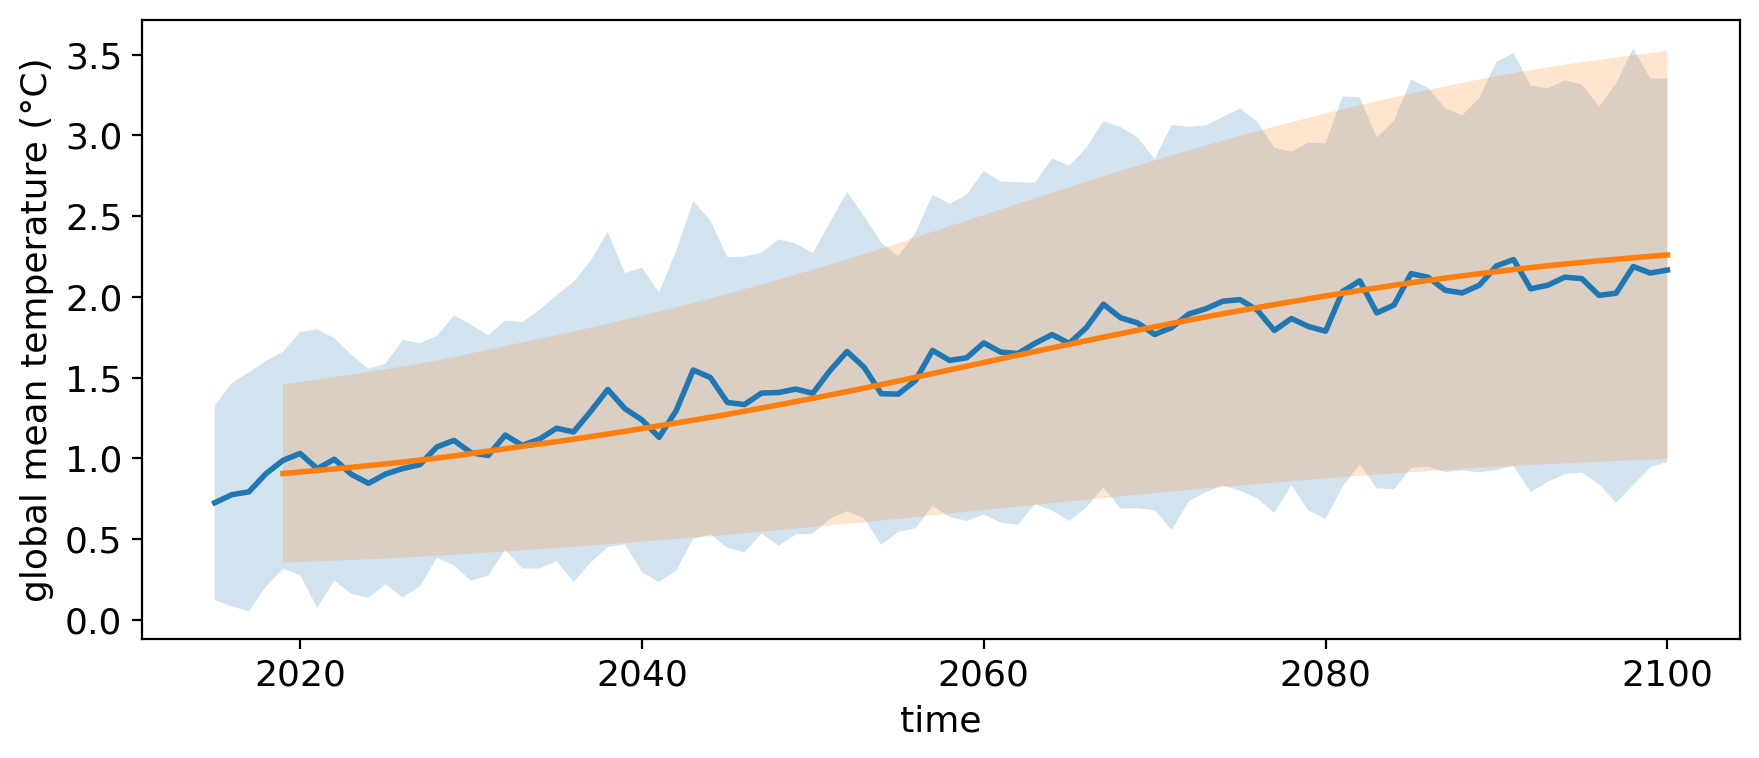

In [19]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
plt.tight_layout()